<a href="https://colab.research.google.com/github/hank199599/data_science_from_scratch_reading_log/blob/main/Chapter21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自然語言處理(NLP,Nature Language Process)
指的是一些與自然語言相關的計算技術

# 單詞雲 (word clouds)
根據單詞出現的次數，來決定字體的大小。

In [1]:
data = [("big data",100,15),("Hadoop",95,25),("Python",75,50),("R",50,40),("machine learning",80,20),("statistics",20,60),("data science",60,70),("analytics",90,3),("team player",85,85),("dynamic",2,90),("synergies",70,0),("actionable insights",40,30),("think out of box",45,10),("self-starter",30,50),("customer focus",65,15),("thought leadership",35,35)]

### 圖 21-1 一個由流行語所組成的單詞雲

In [2]:
!pip3 install wordcloud

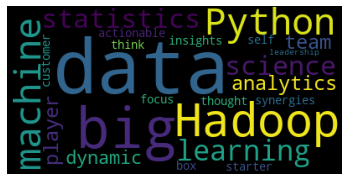

In [3]:
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text=""

for word in data:
  text=text+" "+word[0]

#for word in array:
cloud = WordCloud().generate(text)
plt.imshow(cloud)
plt.axis("off")
plt.show()

### 圖 21-2 一個較有意義的單詞雲

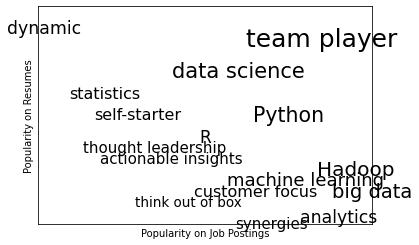

In [4]:
from matplotlib import pyplot as plt

def text_size(total:int) ->float:
  """如果total是0就送出8，如果total是200就送出28"""
  return 8+total/200*20

for word,job_popularity,resume_popularity in data:
  plt.text(job_popularity,resume_popularity,word,ha="center",va="center",size=text_size(job_popularity+resume_popularity))

plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0,100,0,100])
plt.xticks([])
plt.yticks([])
plt.show()

# N-gram 語言模型
找出一堆文件語料庫，然後學習語言的統計模型

## 2-gram (bigram)
1. 針對某個起始單詞，查出原始文件中皆在這個單詞後面的所有單詞
2. 自其中隨機選擇一個做為下一個單詞
3. 重複這個動作(1. 2.)直到選中代表句子結束的句號。

In [5]:
def fix_unicode(text:str) ->str:
  return text.replace(u"\u2019","'")

In [11]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html,'html5lib')

content = soup.find("div","main-post-radar-content")
regex = r"[\w']+|[\.]"

document = []

for paragraph in content("p"):
  words = re.findall(regex,fix_unicode(paragraph.text))
  document.extend(words)

只要其中一個輸入項無資料則結束壓縮，  
運用zip(document,doucment[1:])即可精確取得整個文件的連續單詞對

In [10]:
from collections import defaultdict

transitions = defaultdict(list)
for prev,current in zip(document,document[1:]):
  transitions[prev].append(current)

製作出一些句子

In [15]:
import random

def generate_using_bigrams() ->str:
  current = "." #表示下一個單詞將會是某個句子的起始單詞
  result = []
  while True:
    next_word_candidates = transitions[current]  # bigrams (current,_)
    current = random.choice(next_word_candidates) # 隨機挑選其中一個
    result.append(current)              # 添加至結果後面
    if current == ".":return " ".join(result) # 若遇到「.」就完成了


In [23]:
generate_using_bigrams()

'â Information Platforms as a cost of what does that provides added value from machine learning libraries available Amazon Facebook possibly the results in the direct consequence of question we now ask routinely .'

## 3-gram (trigram)

In [20]:
trigram_transitions = defaultdict(list)
starts = []

for prev,current,next in zip(document,document[1:],document[2:]):

  if prev == ".":
    starts.append(current)
  
  trigram_transitions[(prev,current)].append(next)

In [21]:
def generate_using_trigrams() ->str:
  current = random.choice(starts)
  prev = "."
  result = [current]
  while True:
    next_word_candidates = trigram_transitions[(prev,current)]
    next_word = random.choice(next_word_candidates)

    prev,current = current , next_word
    result.append(current)

    if current == ".":
      return " ".join(result)

In [24]:
generate_using_trigrams()

'If anything can be called a one stop information platform Hadoop is essentially a batch system but Hadoop Online Prototype HOP is an excellent way to develop and tune the application .'

# 文法

# Gibbs 取樣

# 主題模型化

# 單詞向量

# RNN遞迴神經網路

## 字元級RNN